In [198]:
import torch
import sys
import os
sys.path.append(os.path.abspath('../..'))
from data import PVWeatherGenerator, SystemLoader


In [199]:
# data parameters
DAY_INIT = 0
DAY_MIN = 8
DAY_MAX = 16
N_DAYS_FOLD = 7
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 // MINUTE_INTERVAL
N_SYSTEMS = 6
CIRCLE_COORDS = (53.28, -3.05)
RADIUS = 0.25

In [190]:
generator = PVWeatherGenerator(
    coords=CIRCLE_COORDS,
    radius=RADIUS,
    day_init=DAY_INIT,
    n_systems=N_SYSTEMS,
    n_days=365,
    minute_interval=MINUTE_INTERVAL,
)
df = generator.df

==> Loading data
==> Loaded data in: 0 m : 23 sec



In [191]:
individual_interval = int(DAILY_DATA_POINTS * N_DAYS_FOLD)
loader = SystemLoader(df, train_interval=individual_interval)

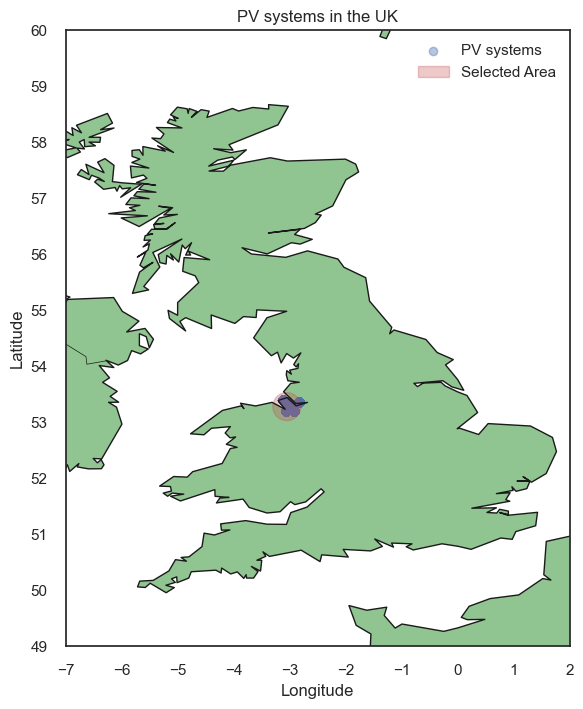

In [192]:
from pv_plot import plot_grid
CIRCLE_COORDS = (53.28, -3.05)
RADIUS = 0.25
plot_grid(df, CIRCLE_COORDS, RADIUS)

In [193]:
x, _,_,_,_,_ = next(iter(loader))
d = x.shape[1]
print(d)

6


In [194]:
from kernels import get_mean_covar_weather

num_tasks = N_SYSTEMS
num_latents = N_SYSTEMS // 2 + 1
mean, covar = get_mean_covar_weather(num_latents=num_latents,
                                      d=d,
                                      combine='product')

interval = 8

Using CPU
Iter 10/100 - Loss: 4.33260561762119
Iter 20/100 - Loss: 0.8507811079956464
Iter 30/100 - Loss: -0.2350060175252351
Iter 40/100 - Loss: -0.853311948363149
Iter 50/100 - Loss: -1.1672216516800484
Iter 60/100 - Loss: -1.321067074385882
Iter 70/100 - Loss: -1.401925275674493
Iter 80/100 - Loss: -1.4384290003856735
Iter 90/100 - Loss: -1.4641462831893146
Iter 100/100 - Loss: -1.4804838689221518


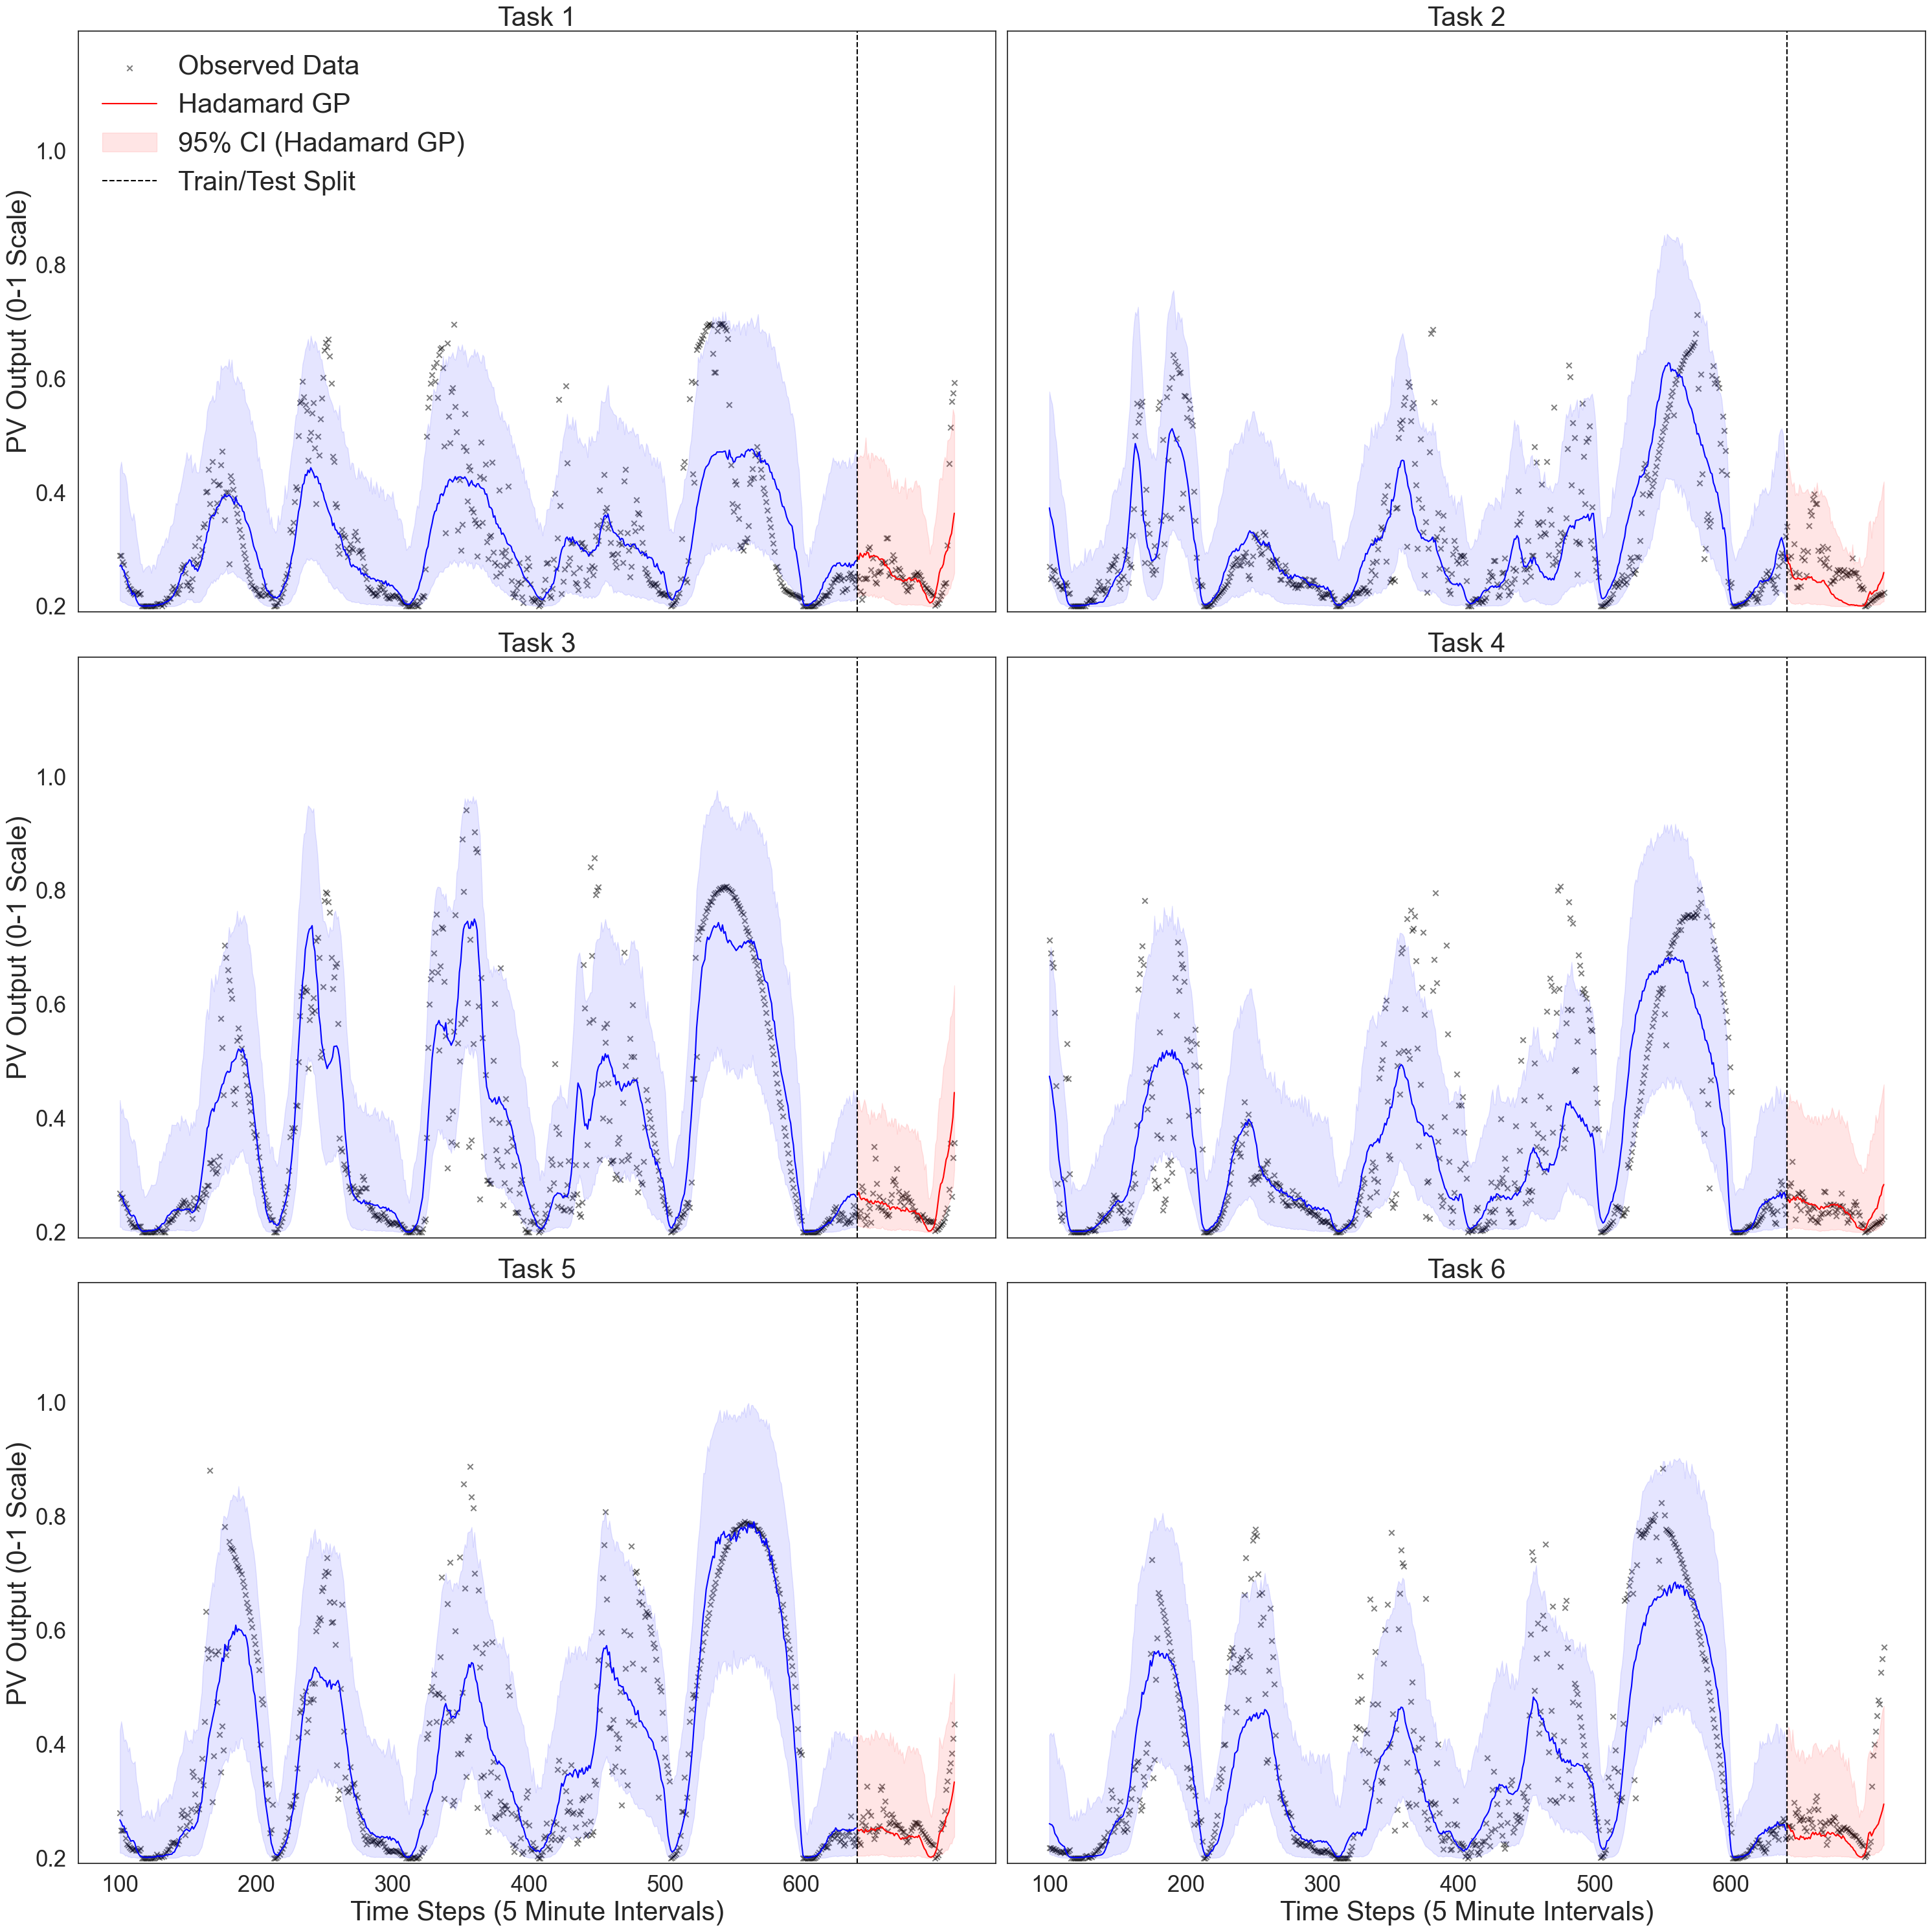

In [202]:
from matplotlib import pyplot as plt
import numpy as np
from models import HadamardGPModel
from likelihoods import HadamardBetaLikelihood
from gpytorch.metrics import negative_log_predictive_density as NLPD

for X_tr, Y_tr, X_te, Y_te, T_tr, T_te in loader:

    fig, ax = plt.subplots(num_tasks // 2, 2, figsize=(30, 5 * (num_tasks)), sharex=True, sharey=True)
    plt.rcParams['font.serif'] = ['Times New Roman']

    ax = ax.flatten()
    mean, covar = get_mean_covar_weather(num_latents, d, combine='product')
    model = HadamardGPModel(
        X=X_tr[::interval],
        y=Y_tr[::interval],
        mean_module=mean,
        covar_module=covar,
        likelihood=HadamardBetaLikelihood(num_tasks=num_tasks, scale=20),
        num_tasks=num_tasks,
        num_latents=num_latents,
        learn_inducing_locations=True,
        inducing_proportion=1.0,
        jitter=1e-6,
    )
    model.set_cpu()
    model.fit(n_iter=100, 
          lr=0.2, 
          task_indices=T_tr[::interval],
          verbose=True)
    model.predict(X_tr, T_tr)
    

    for i in range(num_tasks):
        _, y_tr, _, y_te = loader.train_test_split_individual(i)
        n_tr, n_te = y_tr.shape[0], y_te.shape[0]
        t_tr, t_te = torch.arange(n_tr), torch.arange(n_tr, n_tr+n_te)

        y_pred_tr, lower_tr, upper_tr = model.get_i_prediction(i, T_tr)
        ax[i].scatter(t_tr, y_tr, color='black', marker='x', label='Observed Data', alpha=0.5)
        ax[i].scatter(t_te, y_te, color='black', marker='x', alpha=0.5)
        ax[i].plot(t_tr, y_pred_tr, color='blue')
        ax[i].fill_between(t_tr, lower_tr, upper_tr, color='blue', alpha=0.1)
    
    model.predict(X_te, T_te)
    pred_dist = model.predict_dist()
  
    for i in range(num_tasks):
        x_tr, y_tr, x_te, y_te = loader.train_test_split_individual(i)
        n_tr, n_te = y_tr.shape[0], y_te.shape[0]
        t_tr, t_te = torch.arange(n_tr), torch.arange(n_tr, n_tr+n_te)

        y_pred_te, lower_te, upper_te = model.get_i_prediction(i, T_te)
        if i == 0:
            ax[i].plot(t_te, y_pred_te, color='red', label='Hadamard GP')
            ax[i].fill_between(t_te, lower_te, upper_te, color='red', alpha=0.1, label='95% CI (Hadamard GP)')
        else:
            ax[i].plot(t_te, y_pred_te, color='red')
            ax[i].fill_between(t_te, lower_te, upper_te, color='red', alpha=0.1)
        ax[i].axvline(n_tr, color='black', linestyle='--', label='Train/Test Split')
        ax[i].set_ylim(-0.01, 1.01)
        ax[i].set_title(f'Task {i+1}', fontsize=30)
       
        # set y label for left column
        if i % 2 == 0:
            ax[i].set_ylabel('PV Output (0-1 Scale)', fontsize=30)
            # add y ticks
            y_ticks_rounded = np.round(np.arange(0, 1.1, 0.2), 1)
            ax[i].set_yticklabels(y_ticks_rounded, fontsize=25)
        # set x label for bottom row
        if i >= num_tasks - 2:
            ax[i].set_xlabel('Time Steps (5 Minute Intervals)', fontsize=30)
            # add x ticks
            ax[i].set_xticklabels(np.arange(0, n_tr+n_te, 100), fontsize=25)
        
        if i == 0:
            ax[i].legend(fontsize=30)
      
    for i in range(num_tasks, len(ax)):
        ax[i].axis('off')
    break

plt.tight_layout()
plt.show()


In [196]:
from data.utils import store_gp_module_parameters
store_gp_module_parameters(model)

{'covar_module.kernels.0.outputscale': array([0.2861, 0.2232, 0.1469, 0.0621], dtype=float32),
 'covar_module.kernels.0.base_kernel.lengthscale': array([3.1485, 2.0956, 2.1367, 1.6887], dtype=float32),
 'covar_module.kernels.1.kernels.0.kernels.0.outputscale': array([0.0404, 0.0638, 0.058 , 0.0553], dtype=float32),
 'covar_module.kernels.1.kernels.0.kernels.0.base_kernel.lengthscale': array([1.9746, 2.0104, 1.5318, 0.8938], dtype=float32),
 'covar_module.kernels.1.kernels.0.kernels.0.base_kernel.period_length': array([0.7807, 0.6746, 1.2756, 1.271 ], dtype=float32),
 'covar_module.kernels.1.kernels.0.kernels.1.outputscale': array([0.0404, 0.0638, 0.058 , 0.0553], dtype=float32),
 'covar_module.kernels.1.kernels.0.kernels.1.base_kernel.lengthscale': array([1000.0013, 1000.0046,  999.9996,  999.9987], dtype=float32),
 'covar_module.kernels.1.kernels.1.outputscale': array([0.5169, 0.3194, 0.2393, 0.0838], dtype=float32),
 'covar_module.kernels.1.kernels.1.base_kernel.lengthscale': array([

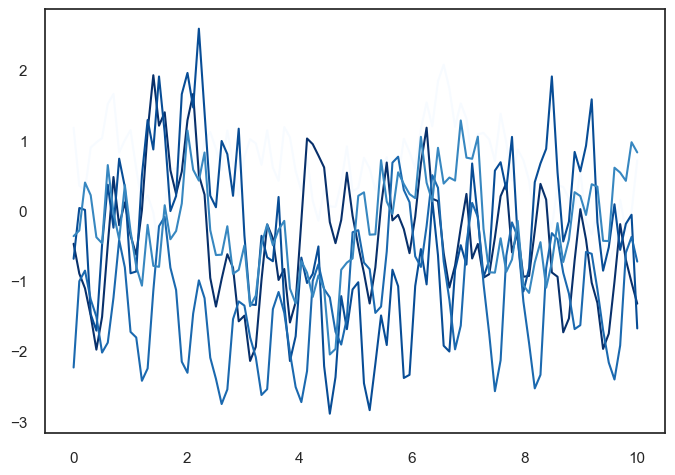

In [197]:
import gpytorch
from kernels import get_mean_covar
mean, covar = get_mean_covar(num_latent=1)
train_x = torch.linspace(0, 10, 100)
train_y = torch.sin(train_x) + torch.randn(train_x.size()) * 0.2
dist = gpytorch.distributions.MultivariateNormal(mean(train_x), covar(train_x))

sample = dist.sample(torch.Size([5]))
# remove middle dimension
sample = sample.squeeze(1)
# plot
cmap = plt.get_cmap("Blues")
colors = [cmap(i) for i in np.linspace(0, 1, 10)]
for i in range(5):
    plt.plot(train_x.numpy(), sample[i].numpy(), label=f"Sample {i}", color=colors[-i])
